# Escuela de ML y DL Módulo 2
# Tarea 3. Detección de manzanas frescas y podridas utilizando Transfer Learning (TL).
# Arnoldo Fernando Chue Sánchez
# arnoldwork20@gmail.com
# Agosto de 2024

## Contenido
1. Planteamiento del problema
2. Planteamiento de la solución
3. Ejemplo de ejecución
4. Conclusiones
5. Referencias

## 1. Planteamiento del problema

Utilizando el modelo pre entrenado de colores (color_weights.hdf5) determinar de un conjunto de manzanas el estado de madurez: fresca o podrida. Entrenar el modelo con las capas de color RGB necesarias para una mejor exactitud.
- Analizar la CNN que se utiliza para el reconocimiento de los colores
- Extraer el dataset de Apples.zip en carpetas de train y test, para frutas frescas y podridas
- Encender las capas de color (extract_color_channel()) necesarias para que el modelo tenga una mejor exactitud
- Ejecutar el modelo
- Mostrar predicciones con el modelo entrenado


## 2. Planteamiento de la solución

Vamos a empezar con los módulos que necesitamos:

Primero evitamos las advertencias de tensorflow al usar la GPU

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import splitfolders
import random 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, Lambda, Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Reshape, Activation, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

2024-08-23 12:25:50.923452: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
tf.config.list_physical_devices('GPU')

2024-08-23 12:26:00.737714: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-23 12:26:00.739204: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-08-23 12:26:00.839443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-23 12:26:00.839790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:06.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.835GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2024-08-23 12:26:00.839850: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-08-23 12:26:01.149455: I tensorflow/stream_executor/platfor

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
Path = ""

El dataset que tenemos ya está dividido en train y test. Sin embargo, vamos a generar un conjunto de validación para cuando estemos haciendo el entrenamiento de la red neuronal. Esto lo podemos hacer gracias a que en el conjunto de entrenamiento hay 1693 imágenes de manzanas frescas y 2342 imágenes de manzanas podridas. Por lo tanto dividiendo con la regla de 80-20 podemos generar un buen conjunto de validación sin disminuir demasiado el conjunto de entrenamiento.

In [5]:
os.makedirs(Path+"train_valid", exist_ok=True)
splitfolders.ratio(Path+"Apples/train/", output=Path+"train_valid", seed=2006, ratio=(0.8,0.2), group_prefix=None, move=False)

Copying files: 4035 files [00:44, 89.84 files/s] 


Verificamos que se haya realizado correctamente

In [6]:
os.listdir(Path+"train_valid/")

['train', 'val']

In [7]:
os.listdir(Path+"train_valid/train/")

['freshapples', 'rottenapples']

In [8]:
print(f"Train fresh: {len(os.listdir(Path+'train_valid/train/freshapples/'))}")
print(f"Train rotten: {len(os.listdir(Path+'train_valid/train/rottenapples/'))}")
print(f"Valid fresh: {len(os.listdir(Path+'train_valid/val/freshapples/'))}")
print(f"Valid rotten: {len(os.listdir(Path+'train_valid/val/rottenapples/'))}")

Train fresh: 1354
Train rotten: 1873
Valid fresh: 339
Valid rotten: 469


Como podemos ver desde ahora, nuestras dos clases están desbalanceadas. Si bien esto podría afectar un poco el desempeño del modelo, por ahora lo vamos a dejar así. Sobre todo podemos confiar en nuestras imágenes de entrenamiento porque ya se les aplicó técnicas de aumento de datos para mejorar el desempeño de la red neuronal.

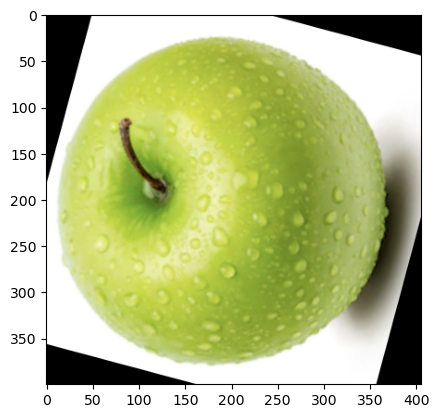

In [9]:
full_path = os.path.join(Path, "train_valid/train/freshapples/")
rand_fresh = os.listdir(full_path)
sample = plt.imread(os.path.join(full_path, random.choice(rand_fresh)))
plt.imshow(sample)

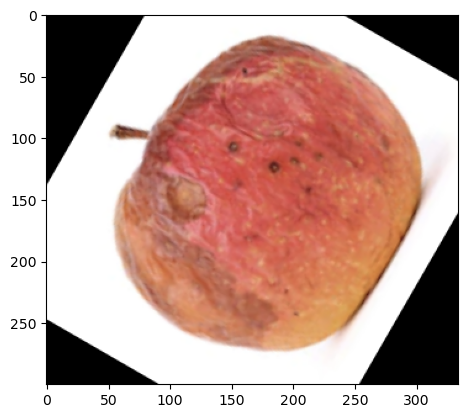

In [10]:
full_path = os.path.join(Path, "train_valid/train/rottenapples/")
rand_fresh = os.listdir(full_path)
sample = plt.imread(os.path.join(full_path, random.choice(rand_fresh)))
plt.imshow(sample)

Con esto ya tenemos nuestros conjuntos listos y podemos comenzar con la transferencia de aprendizaje a la red neuronal que tenemos

Como estamos trabajando transferencia de aprendizaje, debemos retomar la arquitectura de la red neuronal que estamos tomando como base: la red neuronal convolucional especializada en detectar colores. En su momento se usó para detectar colores de hojas de aguacate de acuerdo a su nivel de nitrógeno.

Por lo tanto, vamos a ver su arquitectura para ver en primera instancia cómo se comporta con sus pesos de entrenamiento a este conjunto de datos.

In [14]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(250,250,1))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.7)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.7)(FC_2)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    sgd = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    
    # sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    # sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
    model.compile(optimizer=sgd , loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Ahora bien, como la red neuronal está especializada en color, aquí podemos usar la función que controle qué capas de color RGB podemos usar para el entrenamiento

In [16]:
def extract_green_channel(image):
    # Las imágenes RGB tienen 3 canales: Rojo, Verde y Azul.
    # Para extraer el canal verde, ponemos a cero los canales rojo y azul.
    # La imagen resultante tendrá solo el canal verde.
    color_image = image.copy()  # Crea una copia de la imagen para no modificar la original
    color_image[:, :, 0] = 0  # Canal Rojo
    color_image[:, :, 1] = 1  # Canal Verde
    color_image[:, :, 2] = 0  # Canal Azul
    return color_image

Ahora podemos fijar los primeros parámetros para ver cómo se comporta la red con sus pesos originales para clasificar las manzanas

In [17]:
img_rows, img_cols = 250, 250
num_classes = 2 # tenemos dos clases: fresca y podrida
batch_size = 32 # lo fijamos en este número para que no tarde tanto el entrenamiento por época
num_epochs = 30

In [18]:
# inicializamos el modelo
model = color_net(num_classes)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 60, 60, 48)   5856        ['input_1[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 60, 60, 48)   5856        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 60, 60, 48)  192         ['conv2d[0][0]']             

Cargamos el modelo ya entrenado

In [19]:
filepath = "color_weights.hdf5"

Creamos el checkpoint inicial para este modelo

In [20]:
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Preparamos los conjuntos de entrenamiento, validación y prueba

In [21]:
train_datagen = ImageDataGenerator(
    preprocessing_function=extract_green_channel,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=extract_green_channel,
    rescale=1./255)

test_datagen = ImageDataGenerator(
    preprocessing_function=extract_green_channel,
    rescale=1./255)

In [22]:
traning_set = train_datagen.flow_from_directory(
    Path+"train_valid/train",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_set = validation_datagen.flow_from_directory(
    Path+"train_valid/val",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    Path+"Apples/test",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

total_samples = traning_set.n

Found 3227 images belonging to 2 classes.
Found 808 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


In [26]:
history_original = model.fit(
    traning_set,
    epochs=num_epochs,
    validation_data=validation_set,
    callbacks=callbacks_list)

Epoch 1/30
101/101 [==============================] - 76s 747ms/step - loss: 0.6802 - accuracy: 0.5804 - val_loss: 0.6801 - val_accuracy: 0.5804
Epoch 2/30
101/101 [==============================] - 76s 750ms/step - loss: 0.6804 - accuracy: 0.5804 - val_loss: 0.6802 - val_accuracy: 0.5804
Epoch 3/30
101/101 [==============================] - 77s 766ms/step - loss: 0.6802 - accuracy: 0.5804 - val_loss: 0.6802 - val_accuracy: 0.5804
Epoch 4/30
101/101 [==============================] - 79s 782ms/step - loss: 0.6805 - accuracy: 0.5804 - val_loss: 0.6802 - val_accuracy: 0.5804
Epoch 5/30
101/101 [==============================] - 59s 586ms/step - loss: 0.6809 - accuracy: 0.5804 - val_loss: 0.6802 - val_accuracy: 0.5804
Epoch 6/30
101/101 [==============================] - 47s 467ms/step - loss: 0.6808 - accuracy: 0.5804 - val_loss: 0.6802 - val_accuracy: 0.5804
Epoch 7/30
101/101 [==============================] - 48s 477ms/step - loss: 0.6811 - accuracy: 0.5804 - val_loss: 0.6802 - val_ac

Como podemos ver hubo dos aspectos negativos con esta propuesta de modelo:
- La red a pesar del entrenamietno no logró bajar la función de pérdida y sobre todo no logró aprender: se mantuvo con un accuracy del 58.04% en el conjunto de validación
- Además, por un error de escritura, el checkpoint no pudo guardar el modelo. Eso lo podemos corregir. Sin embargo, el hecho de que le fuera tan mal al modelo hace que no nos preocupe tanto que no se guardara este checkpoint.

Por lo tanto, vamos a corregirlo y además vamos a ver cómo le va al modelo original con el conjunto de prueba

In [27]:
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [28]:
model.evaluate(test_set)

32/32 [==============================] - 4s 114ms/step - loss: 0.6725 - accuracy: 0.6034


[0.672478437423706, 0.6034136414527893]

In [33]:
shutil.rmtree(Path+"modelo1_tarea3", ignore_errors=True)
model.save(Path+"modelo1_tarea3", save_format="tf")

INFO:tensorflow:Assets written to: modelo1_tarea3\assets


INFO:tensorflow:Assets written to: modelo1_tarea3\assets


Si bien el modelo mejoró, hasta ahorita podemos ver que en realidad si tomamos el modelo como está con la arquitectura original y sólo tomamos el color verde, estaríamos haciendo una transferencia negativa.

Por lo tanto, aquí propongo una mejora para la arquitectura:
- Las capas de Dropout de la parte completamente conectada vamos a dejarlas con un 30% porque con el 70% original son demasiadas las neuronas que se "apagan"
- Vamos a agregar una capa adicional a la parte completamente conectada: una de 1024 neuronas con su respectivo dropout
- Vamos a entrenarla con el optimizador Adam, con la tasa de aprendizaje por defecto
- Al usar el optimizador adam, vamos a bajar a 20 el número de épocas
- El tamaño del lote vamos a reducirlo a 25 para reducir el tiempo de entrenamiento
- Vamos a activar todas las capas de color del RGB (no sólo la de verde)

In [39]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(250,250,3))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.3)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.3)(FC_2)
    FC_3 = Dense(units=1024, activation='relu')(FC_2)
    FC_3 = Dropout(0.3)(FC_3)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    
    #Modelo Adam
    adam= Adam()
    model.compile(optimizer=adam , loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [40]:
def extract_green_channel(image):
    # Las imágenes RGB tienen 3 canales: Rojo, Verde y Azul.
    # Para extraer el canal verde, ponemos a cero los canales rojo y azul.
    # La imagen resultante tendrá solo el canal verde.
    color_image = image.copy()  # Crea una copia de la imagen para no modificar la original
    color_image[:, :, 0] = 1  # Canal Rojo
    color_image[:, :, 1] = 1  # Canal Verde
    color_image[:, :, 2] = 1  # Canal Azul
    return color_image

In [41]:
num_epochs = 20
batch_size = 25
model1 = color_net(num_classes)

In [42]:
train_datagen = ImageDataGenerator(
    preprocessing_function=extract_green_channel,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=extract_green_channel,
    rescale=1./255)

test_datagen = ImageDataGenerator(
    preprocessing_function=extract_green_channel,
    rescale=1./255)

In [43]:
traning_set = train_datagen.flow_from_directory(
    Path+"train_valid/train",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_set = validation_datagen.flow_from_directory(
    Path+"train_valid/val",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    Path+"Apples/test",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

total_samples = traning_set.n

Found 3227 images belonging to 2 classes.
Found 808 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


In [44]:
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 60, 60, 48)   17472       ['input_4[0][0]']                
                                                                                                  
 conv2d_56 (Conv2D)             (None, 60, 60, 48)   17472       ['input_4[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 60, 60, 48)  192         ['conv2d_48[0][0]']        

In [45]:
history1 = model1.fit(
    traning_set,
    epochs=num_epochs,
    validation_data=validation_set,
    callbacks=callbacks_list
)

Epoch 1/20
130/130 [==============================] - 50s 365ms/step - loss: 0.6849 - accuracy: 0.5693 - val_loss: 0.6836 - val_accuracy: 0.5804
Epoch 2/20
130/130 [==============================] - 45s 345ms/step - loss: 0.6828 - accuracy: 0.5779 - val_loss: 0.6802 - val_accuracy: 0.5804
Epoch 3/20
130/130 [==============================] - 45s 347ms/step - loss: 0.6809 - accuracy: 0.5804 - val_loss: 0.6804 - val_accuracy: 0.5804
Epoch 4/20
130/130 [==============================] - 49s 376ms/step - loss: 0.6806 - accuracy: 0.5804 - val_loss: 0.6810 - val_accuracy: 0.5804
Epoch 5/20
130/130 [==============================] - 49s 375ms/step - loss: 0.6805 - accuracy: 0.5804 - val_loss: 0.6810 - val_accuracy: 0.5804
Epoch 6/20
130/130 [==============================] - 53s 407ms/step - loss: 0.6816 - accuracy: 0.5804 - val_loss: 0.6802 - val_accuracy: 0.5804
Epoch 7/20
130/130 [==============================] - 49s 380ms/step - loss: 0.6811 - accuracy: 0.5804 - val_loss: 0.6802 - val_ac

Como podemos ver, tenemos exactamente el mismo resultado que con la arquitectura original. Nuestros cambios no hicieron ningún efecto. Igualmente vamos a ver cómo le van con las imágenes de prueba. Sin embargo, esto parece algo atípico

In [46]:
model1.evaluate(test_set)

40/40 [==============================] - 4s 106ms/step - loss: 0.6749 - accuracy: 0.6034


[0.6749264001846313, 0.6034136414527893]

In [63]:
shutil.rmtree(Path+"modelo2_tarea3", ignore_errors=True)
model1.save(Path+"modelo2_tarea3", save_format="tf")

INFO:tensorflow:Assets written to: modelo2_tarea3\assets


INFO:tensorflow:Assets written to: modelo2_tarea3\assets


Volvemos a tener los mismos resultados. Sólo para verificar vamos a hacer una pequeña red neuronal convolucional de nuestra invención para observar si por lo menos el aprendizaje se modifica un poco. Lo único es que vamos a retomar la función de activación de colores y en esta ocasión solamente activaremos el rojo.

In [58]:
def extract_color_channel(image):
    # Las imágenes RGB tienen 3 canales: Rojo, Verde y Azul.
    # Para extraer el canal verde, ponemos a cero los canales rojo y azul.
    # La imagen resultante tendrá solo el canal verde.
    color_image = image.copy()  # Crea una copia de la imagen para no modificar la original
    color_image[:, :, 0] = 1  # Canal R=Rojo
    color_image[:, :, 1] = 0  # Canal G=Verde
    color_image[:, :, 2] = 0  # Canal B=Azul
    return color_image

In [55]:
model2 = keras.models.Sequential([
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(250,250,3)),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(756, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(372, activation='relu'),
    keras.layers.Dense(123, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

In [56]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 124, 124, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 61, 61, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 29, 29, 64)       0

In [57]:
model2.compile(optimizer="adam", loss="categorical_crossentropy",
               metrics=["accuracy"])

In [59]:
img_rows , img_cols = 250,250
batch_size = 32
numb_epoch = 20

train_datagen = ImageDataGenerator(
        preprocessing_function=extract_color_channel,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(
        preprocessing_function=extract_color_channel,
        rescale=1./255)

training_set = train_datagen.flow_from_directory(
            'Apples/train',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical')
test_set = test_datagen.flow_from_directory(
            'Apples/test',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical')

Found 4035 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


In [61]:
history2 = model2.fit(
    training_set,
    epochs=num_epochs,
    validation_data=test_set,
)

Epoch 1/20
127/127 [==============================] - 65s 509ms/step - loss: 0.6815 - accuracy: 0.5804 - val_loss: 0.6731 - val_accuracy: 0.6034
Epoch 2/20
127/127 [==============================] - 97s 761ms/step - loss: 0.6807 - accuracy: 0.5804 - val_loss: 0.6767 - val_accuracy: 0.6034
Epoch 3/20
127/127 [==============================] - 96s 753ms/step - loss: 0.6812 - accuracy: 0.5804 - val_loss: 0.6747 - val_accuracy: 0.6034
Epoch 4/20
127/127 [==============================] - 95s 748ms/step - loss: 0.6811 - accuracy: 0.5804 - val_loss: 0.6740 - val_accuracy: 0.6034
Epoch 5/20
127/127 [==============================] - 96s 755ms/step - loss: 0.6806 - accuracy: 0.5804 - val_loss: 0.6736 - val_accuracy: 0.6034
Epoch 6/20
 24/127 [====>.........................] - ETA: 1:11 - loss: 0.6775 - accuracy: 0.5927

KeyboardInterrupt: 

Como vemos el modelo 2 con una arquitectura mucho más simple pareciera que apenas alcanza un 2% más que la arquitectura robusta a la que estamos tratando de hacer transferencia de aprendizaje.

Podemos probar haciendo más compleja la arquitectura de nuestra versión de red neuronal. Sin embargo, posiblemente nos encontraríamos con este problema: los optimizadores están llegando a mínimos locales (o posiblemente globales) muy pronto. Y eso impide que alcancemos mejores resultados, independientemente de la arquitectura de la red.


In [62]:
shutil.rmtree(Path+"modelo3_tarea3", ignore_errors=True)
model2.save(Path+"modelo3_tarea3", save_format="tf")

INFO:tensorflow:Assets written to: modelo3_tarea3\assets


INFO:tensorflow:Assets written to: modelo3_tarea3\assets


Vamos a intentar una vez más con la arquitectura original de la red. En esta ocasión vamos a usar conjunto de entrenamiento, validación y prueba. Además, vamos a agregar una arquitectura completamente diferente a la parte densa. En cuanto al color que activaremos solamente trabajaremos con el rojo y el verde. 

Para tratar de comprobar nuestra hipótesis sobre entrar en un mínimo local-global del que no podemos salir, vamos a usar un optimizador completamente diferente. Dado que esto es sólo una prueba, vamos a usar sólo unas pocas épocas para ver si logra moverse el accuracy aunque sea un poco a lo largo de estas.

In [64]:
def extract_color_channel(image):
    # Las imágenes RGB tienen 3 canales: Rojo, Verde y Azul.
    # Para extraer el canal verde, ponemos a cero los canales rojo y azul.
    # La imagen resultante tendrá solo el canal verde.
    color_image = image.copy()  # Crea una copia de la imagen para no modificar la original
    color_image[:, :, 0] = 1  # Canal R=Rojo
    color_image[:, :, 1] = 1  # Canal G=Verde
    color_image[:, :, 2] = 0  # Canal B=Azul
    return color_image

In [74]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(250,250,3))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=512, activation='relu')(flatten)
    FC_1 = Dropout(0.3)(FC_1)
    FC_2 = Dense(units=1024, activation='relu')(FC_1)
    FC_2 = Dropout(0.5)(FC_2)
    FC_3 = Dense(units=2056, activation='relu')(FC_2)
    FC_3 = Dropout(0.3)(FC_3)
    FC_4 = Dense(units=2056, activation='relu')(FC_3)
    FC_4 = Dropout(0.3)(FC_4)
    FC_5 = Dense(units=64, activation='relu')(FC_4)

    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    
    #Modelo Adam
    optimizador = Nadam()
    model.compile(optimizer=optimizador , loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [75]:
img_rows, img_cols = 250, 250
num_classes = 2 # tenemos dos clases: fresca y podrida
batch_size = 32 # lo fijamos en este número para que no tarde tanto el entrenamiento por época
num_epochs = 10

In [76]:
model3 = color_net(num_classes)

In [77]:
model3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_115 (Conv2D)            (None, 60, 60, 48)   17472       ['input_8[0][0]']                
                                                                                                  
 conv2d_123 (Conv2D)            (None, 60, 60, 48)   17472       ['input_8[0][0]']                
                                                                                                  
 batch_normalization_42 (BatchN  (None, 60, 60, 48)  192         ['conv2d_115[0][0]']       

In [78]:
train_datagen = ImageDataGenerator(
    preprocessing_function=extract_green_channel,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=extract_green_channel,
    rescale=1./255)

test_datagen = ImageDataGenerator(
    preprocessing_function=extract_green_channel,
    rescale=1./255)

In [79]:
traning_set = train_datagen.flow_from_directory(
    Path+"train_valid/train",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_set = validation_datagen.flow_from_directory(
    Path+"train_valid/val",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    Path+"Apples/test",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

total_samples = traning_set.n

Found 3227 images belonging to 2 classes.
Found 808 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


In [80]:
history3 = model3.fit(
    training_set,
    epochs=num_epochs,
    validation_data=validation_set,
    callbacks=callbacks_list
)

Epoch 1/10
127/127 [==============================] - 109s 799ms/step - loss: 0.6856 - accuracy: 0.5787 - val_loss: 0.6802 - val_accuracy: 0.5804
Epoch 2/10
127/127 [==============================] - 134s 1s/step - loss: 0.6813 - accuracy: 0.5804 - val_loss: 0.6802 - val_accuracy: 0.5804
Epoch 3/10
127/127 [==============================] - 149s 1s/step - loss: 0.6814 - accuracy: 0.5804 - val_loss: 0.6802 - val_accuracy: 0.5804
Epoch 4/10
127/127 [==============================] - 147s 1s/step - loss: 0.6808 - accuracy: 0.5804 - val_loss: 0.6805 - val_accuracy: 0.5804
Epoch 5/10
127/127 [==============================] - 141s 1s/step - loss: 0.6809 - accuracy: 0.5804 - val_loss: 0.6829 - val_accuracy: 0.5804
Epoch 6/10
127/127 [==============================] - 147s 1s/step - loss: 0.6813 - accuracy: 0.5804 - val_loss: 0.6817 - val_accuracy: 0.5804
Epoch 7/10
127/127 [==============================] - 144s 1s/step - loss: 0.6809 - accuracy: 0.5804 - val_loss: 0.6810 - val_accuracy: 0.5

Seguimos viendo que el accuracy se estanca en 58.04%, aun con diferentes arquitecturas, tanto para la parte convolucional, como para la parte completamente conexa.

In [81]:
model3.evaluate(test_set)

32/32 [==============================] - 7s 197ms/step - loss: 0.6770 - accuracy: 0.6034


[0.6769856810569763, 0.6034136414527893]

Y con los mismos resultados para el conjunto de prueba...

In [82]:
shutil.rmtree(Path+"modelo4_tarea3", ignore_errors=True)
model3.save(Path+"modelo4_tarea3", save_format="tf")

INFO:tensorflow:Assets written to: modelo4_tarea3\assets


INFO:tensorflow:Assets written to: modelo4_tarea3\assets


Otra posibilidad es que nuestra función con la que "apagamos" o "prendemos" las capas de color esté modificando de forma errónea las imágenes. Porque en realidad tomar una de las 3 matrices e igualarla a 0 o 1 no es formalmente que la tome o no en cuenta la red neuronal, sino más bien la estás volviendo completamente negra o blanca. Si ese es el caso de la moficación de imágenes no sólo perdería el sentido la detección de color. También así se explicaría la razón de que estemos obteniendo el mismo accuracy para cualquier red neuronal. 

Por lo tanto:
- Vamos a entrenas una red sin esa función de apagar o prender colores
- Vamos a usar la arquitectura propuesta para mejorar la red neuronal original: respetar la convolución de los autores, aumentar la parte densa, dejar capas de dropout de las capas densas al 30% y usar el optimizador Adam

In [14]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(250,250,1))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    # Aquí van nuestras modificaciones
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.3)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.3)(FC_2)
    FC_3 = Dense(units=1024, activation='relu')(FC_2)
    FC_3 = Dropout(0.3)(FC_3)
    FC_4 = Dense(units=256, activation='relu')(FC_3)
    FC_4 = Dropout(0.3)(FC_4)
    FC_5 = Dense(units=64, activation='relu')(FC_4)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    
    adam = Adam(learning_rate=1e-3)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
img_rows, img_cols = 250, 250
num_classes = 2
batch_size = 32
num_epochs = 20

In [16]:
model4 = color_net(num_classes)

In [17]:
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 60, 60, 48)   5856        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 60, 60, 48)   5856        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 60, 60, 48)   192         conv2d_16[0][0]                  
______________________________________________________________________________________________

In [18]:
filepath = "color_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
callbacks_list = checkpoint

Al preparar los conjuntos de entrenamiento, validación y pruebas evitamos usar la función de extracción de verde

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    rescale=1./255)

test_datagen = ImageDataGenerator(
    rescale=1./255)

traning_set = train_datagen.flow_from_directory(
    Path+"train_valid/train",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_set = validation_datagen.flow_from_directory(
    Path+"train_valid/val",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    Path+"Apples/test",
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical'
)

total_samples = traning_set.n

Found 3227 images belonging to 2 classes.
Found 808 images belonging to 2 classes.
Found 996 images belonging to 2 classes.


In [20]:
history4 = model4.fit(
    traning_set,
    epochs=num_epochs,
    validation_data=validation_set,
    callbacks=callbacks_list
)

2024-08-23 12:51:58.313261: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-08-23 12:51:58.343253: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2261055000 Hz


Epoch 1/20


2024-08-23 12:52:00.767242: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-08-23 12:52:02.268601: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


101/101 [==============================] - 88s 785ms/step - loss: 4.4955 - accuracy: 0.6581 - val_loss: 0.7221 - val_accuracy: 0.5705
Epoch 2/20
101/101 [==============================] - 78s 773ms/step - loss: 0.4135 - accuracy: 0.8479 - val_loss: 0.5281 - val_accuracy: 0.7141
Epoch 3/20
101/101 [==============================] - 78s 773ms/step - loss: 0.2475 - accuracy: 0.9193 - val_loss: 0.2044 - val_accuracy: 0.9233
Epoch 4/20
101/101 [==============================] - 78s 773ms/step - loss: 0.1839 - accuracy: 0.9254 - val_loss: 0.2030 - val_accuracy: 0.9196
Epoch 5/20
101/101 [==============================] - 78s 773ms/step - loss: 0.1659 - accuracy: 0.9311 - val_loss: 0.3320 - val_accuracy: 0.8762
Epoch 6/20
101/101 [==============================] - 78s 771ms/step - loss: 0.2151 - accuracy: 0.9117 - val_loss: 0.2280 - val_accuracy: 0.9146
Epoch 7/20
101/101 [==============================] - 78s 774ms/step - loss: 0.1882 - accuracy: 0.9241 - val_loss: 0.6165 - val_accuracy: 0.6

Como podemos ver a lo largo de las épocas: por fin logramos una transferencia de aprendizaje positiva para nuestra red neuronal. Claramente el problema era la función "extract_color_channel".

Pasemos entonces con el ánalisis de este modelo

In [21]:
shutil.rmtree(Path+"modelo5_tarea3", ignore_errors=True)
model4.save(Path+"modelo5_tarea3", save_format="tf")

2024-08-23 13:23:05.364113: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: modelo5_tarea3/assets


## 3. Ejemplo de solución

Veamos el comportamiento del modelo a lo largo de las épocas, porque al observar las métricas parece que la accuracy fue muy inestable en el entrenamiento: estuvo en un rango del 41% al 93%.

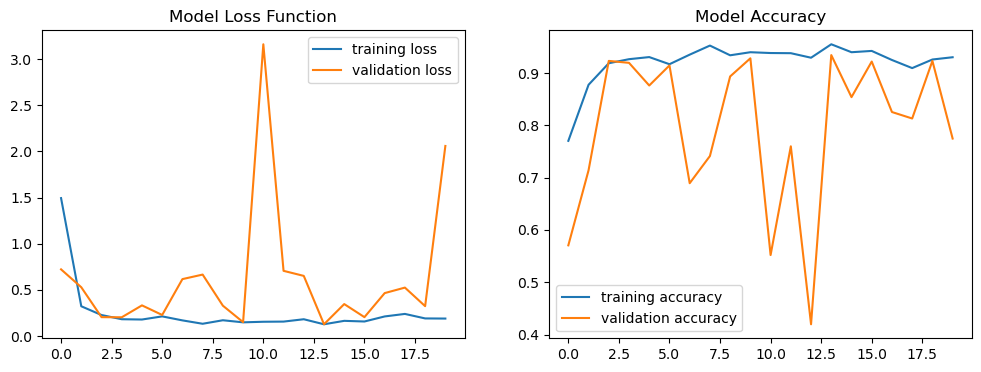

In [23]:
history_df = pd.DataFrame(history4.history)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend()

Justo con las gráficas podemos ver que la efectividad del modelo en algunas épocas se desplomó, mostrando casos muy graves de sobreajuste en esos casos. Sin embargo, cuando el modelo consiguió estar por encima del 90% lo hizo bien tanto en entrenamiento como validación: mostrando así que sí hay parámetros adecuados para la predicción de manzanas frescas y podridas.

Veamos entonces cómo le va con el conjunto de prueba:

In [24]:
model4.evaluate(test_set)

32/32 [==============================] - 10s 316ms/step - loss: 1.8788 - accuracy: 0.7701


[1.8788269758224487, 0.7700803279876709]

Al evaluarlo así vemos que se queda en el 77% justo como en la última época. Si bien es un resultado esperado por la poca cantidad de imágenes que tenemos, podemos acceder al modelo que en una de las épocas alcanzó 93% de accuracy y ver sus predicciones:

In [27]:
best_model = load_model(filepath)

best_model.evaluate(test_set)

32/32 [==============================] - 6s 167ms/step - loss: 0.1052 - accuracy: 0.9458


[0.10520925372838974, 0.9457831382751465]

Como podemos ver, nuestra transferencia fue muy exitosa: 94.57% de efectividad. Nuestro mejor resultado hasta ahora a lo largo del diplomado.

## 4. Conclusiones

En esta práctica aplicamos no solamente las ideas para hacer transferencia de aprendizaje, sino también conceptos que ya habíamos visto de las redes neuronales convolucionales y completamente conexas. Además, como pudimos ver, no importa tanto al arquitectura de una red neuronal si no haces el procesamiendo adecuado de las imágenes. 

Esto último fue la clave para poder terminar la práctica y una muestra que al hacer redes neuronales tienes también que tener buenas habilidades para encontrar errores en el códico.

En cuanto a la transferencia de aprendizaje, para trabajos futuros sería interesante hacerla pero congelando y descongelando capas en el entrenamiento. Sobre todo porque cuando entrenamos las modificaciones la parte densa, sí llegamos a pasarle ruido a la parte convolucional por la propagación hacia atrás del error.

Respecto al modelo ganador: ahora el trabajo se debería centrar a seguir haciendo transferencia de aprendizaje, pero con conjuntos de datos de otros tipos de frutas. Una red neuronal así puesta en producción sería muy útil en cualquier lugar donde se consuma o venda mucha fruta.

## 5. Referencias

En esta ocasión solamente nos remitimos a la documentación oficial de Keras sobre los optimizadores y el checkpoint para guardar el mejor modelo durante el entrenamiento:
- https://keras.io/api/optimizers/
- https://keras.io/api/callbacks/model_checkpoint/